# Libraries

In [ ]:
!pip install evaluate seqeval

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from evaluate import load
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

In [ ]:
from transformers import pipeline

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from datasets import Dataset, DatasetDict
import json
import numpy as np
from evaluate import load
from collections import Counter
import matplotlib.pyplot as plt
import hashlib
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
from tqdm import tqdm

# Fine-tuning

In [ ]:
def load_and_preprocess_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    unique_entries = {}
    for entry in data:
        text_hash = hashlib.md5(" ".join(entry["text"]).encode()).hexdigest()
        labels_hash = hashlib.md5(" ".join(entry["labels"]).encode()).hexdigest()
        unique_id = f"{text_hash}_{labels_hash}"

        if unique_id not in unique_entries:
            unique_entries[unique_id] = entry

    print(f"Removed {len(data) - len(unique_entries)} duplicates")
    return list(unique_entries.values())

file_path = "data.json"
data = load_and_preprocess_data(file_path)

Removed 516 duplicates


In [ ]:
def create_label_mapping(data):
    all_labels = set()
    for entry in data:
        all_labels.update(entry["labels"])

    label_to_id = {"O": 0}
    id_counter = 1

    for label in sorted(all_labels):
        if label != "O" and label not in label_to_id:
            label_to_id[label] = id_counter
            id_counter += 1

    return label_to_id

label_to_id = create_label_mapping(data)
id_to_label = {id: label for label, id in label_to_id.items()}

print("\nLabel mapping:")
for label, id in label_to_id.items():
    print(f"{label}: {id}")


Label mapping:
O: 0
B-ACTION: 1
B-ITEM: 2
B-LOC: 3
B-MON: 4
B-ORG: 5
B-PER: 6
B-SPELL: 7
B-STATUS: 8
I-ACTION: 9
I-ITEM: 10
I-LOC: 11
I-MON: 12
I-ORG: 13
I-PER: 14
I-SPELL: 15
I-STATUS: 16


In [ ]:
def convert_to_dataset_format(data, label_to_id):
    tokens_list = []
    ner_tags_list = []

    for entry in data:
        tokens_list.append(entry["text"])
        ner_tags_list.append([label_to_id[label] for label in entry["labels"]])

    return {
        'tokens': tokens_list,
        'ner_tags': ner_tags_list
    }

dataset_dict = convert_to_dataset_format(data, label_to_id)
dnd_dataset = Dataset.from_dict(dataset_dict)

dnd_dataset = dnd_dataset.train_test_split(test_size=0.2, seed=42)
dnd_dataset = DatasetDict({
    'train': dnd_dataset['train'],
    'validation': dnd_dataset['test']
})

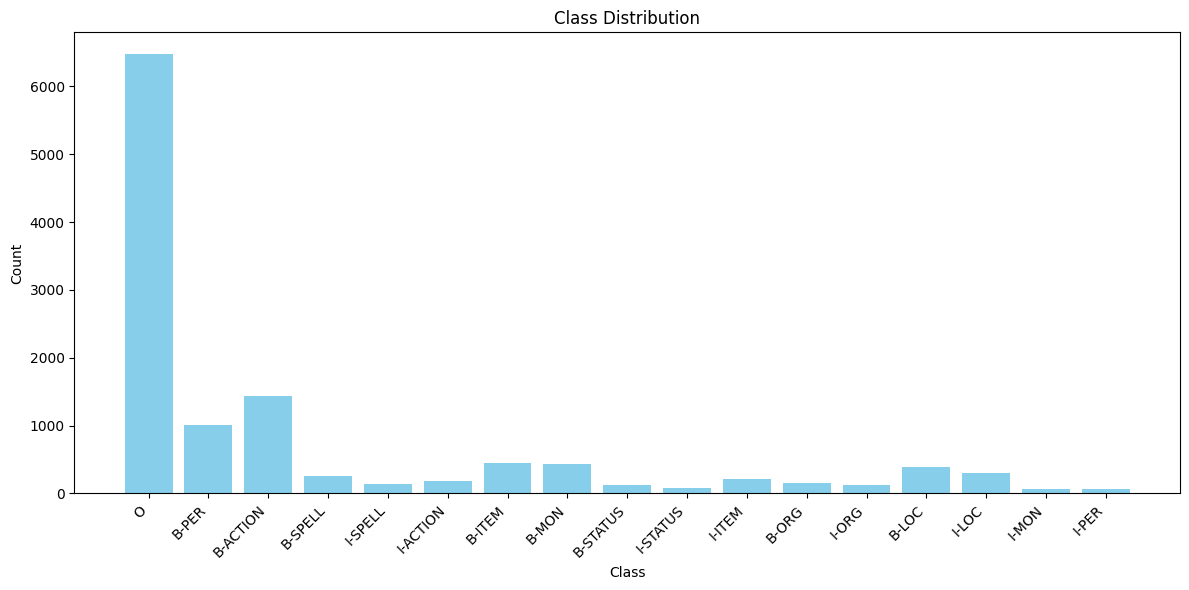


Class Distribution:
O: 6474 (54.38%)
B-PER: 1003 (8.43%)
B-ACTION: 1439 (12.09%)
B-SPELL: 259 (2.18%)
I-SPELL: 134 (1.13%)
I-ACTION: 189 (1.59%)
B-ITEM: 450 (3.78%)
B-MON: 429 (3.60%)
B-STATUS: 130 (1.09%)
I-STATUS: 78 (0.66%)
I-ITEM: 220 (1.85%)
B-ORG: 149 (1.25%)
I-ORG: 118 (0.99%)
B-LOC: 395 (3.32%)
I-LOC: 307 (2.58%)
I-MON: 62 (0.52%)
I-PER: 69 (0.58%)


In [ ]:
def analyze_class_distribution(dataset):
    all_labels = []
    for example in dataset:
        labels = [label for label in example["ner_tags"]]
        all_labels.extend(labels)

    label_counts = Counter(all_labels)
    total = len(all_labels)

    plt.figure(figsize=(12, 6))
    names = [id_to_label[id] for id in label_counts.keys()]
    values = list(label_counts.values())

    plt.bar(names, values, color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300)
    plt.show()

    print("\nClass Distribution:")
    for label_id, count in label_counts.items():
        label_name = id_to_label[label_id]
        percentage = count / total * 100
        print(f"{label_name}: {count} ({percentage:.2f}%)")

    return label_counts

train_label_counts = analyze_class_distribution(dnd_dataset['train'])

In [ ]:
model_name = "boltuix/EntityBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_to_id),
    id2label=id_to_label,
    label2id=label_to_id,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at boltuix/EntityBERT and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([37]) in the checkpoint and torch.Size([17]) in the model instantiated
- classifier.weight: found shape torch.Size([37, 128]) in the checkpoint and torch.Size([17, 128]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, ner_tags in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                if word_idx < len(ner_tags):
                    label_ids.append(ner_tags[word_idx])
                else:
                    label_ids.append(label_to_id["O"])
            else:
                label_ids.append(-100)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dd = dnd_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dnd_dataset['train'].column_names
)

Map:   0%|          | 0/1187 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

## pytorch train

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
def create_weighted_dataloader(dataset, class_weights, batch_size=8):
    sample_weights = []
    for example in dataset:
        weight = 1.0
        for label_id in example["labels"]:
            if label_id != -100:
                weight = max(weight, class_weights[label_id])
        sample_weights.append(weight)

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        collate_fn=data_collator,
        pin_memory=True
    )

In [ ]:
train_dataloader = create_weighted_dataloader(
    tokenized_dd["train"],
    class_weights.numpy(),
    batch_size=8
)

eval_dataloader = DataLoader(
    tokenized_dd["validation"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=False
)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
num_training_steps = len(train_dataloader) * 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_training_steps)

In [ ]:
def compute_metrics(predictions, labels):
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for i in range(len(predictions)):
        preds = []
        labs = []
        for j in range(len(predictions[i])):
            if labels[i][j] != -100:
                preds.append(id_to_label[predictions[i][j]])
                labs.append(id_to_label[labels[i][j]])

        true_predictions.append(preds)
        true_labels.append(labs)

    return seqeval.compute(
        predictions=true_predictions,
        references=true_labels,
        mode="strict",
        scheme="IOB2"
    )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

best_f1 = 0
for epoch in range(20):
    print(f"\nEpoch {epoch+1}/20")

    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            val_loss += outputs.loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_predictions.append(logits)
            all_labels.append(labels)

    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Average validation loss: {avg_val_loss:.4f}")

    predictions = np.concatenate(all_predictions, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    metrics = compute_metrics(predictions, labels)

    print(f"Validation F1: {metrics['overall_f1']:.4f}")
    print(f"Validation Precision: {metrics['overall_precision']:.4f}")
    print(f"Validation Recall: {metrics['overall_recall']:.4f}")

    if metrics['overall_f1'] > best_f1:
        best_f1 = metrics['overall_f1']
        model.save_pretrained("best_dnd_ner_model")
        tokenizer.save_pretrained("best_dnd_ner_model")
        print("Saved best model!")

    model.train()

model.save_pretrained("final_dnd_ner_model")
tokenizer.save_pretrained("final_dnd_ner_model")
print("\nTraining completed!")


Epoch 1/20


Training: 100%|██████████| 149/149 [00:04<00:00, 33.00it/s, loss=0.537]


Average training loss: 0.7085


Validation: 100%|██████████| 19/19 [00:00<00:00, 103.48it/s]


Average validation loss: 0.5970
Validation F1: 0.7410
Validation Precision: 0.6967
Validation Recall: 0.7913
Saved best model!

Epoch 2/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.25it/s, loss=0.637]


Average training loss: 0.7115


Validation: 100%|██████████| 19/19 [00:00<00:00, 103.11it/s]


Average validation loss: 0.5889
Validation F1: 0.7456
Validation Precision: 0.7005
Validation Recall: 0.7969
Saved best model!

Epoch 3/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.07it/s, loss=0.875]


Average training loss: 0.7064


Validation: 100%|██████████| 19/19 [00:00<00:00, 112.23it/s]


Average validation loss: 0.5788
Validation F1: 0.7445
Validation Precision: 0.6938
Validation Recall: 0.8033

Epoch 4/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.15it/s, loss=0.486]


Average training loss: 0.6607


Validation: 100%|██████████| 19/19 [00:00<00:00, 107.20it/s]


Average validation loss: 0.5531
Validation F1: 0.7450
Validation Precision: 0.7024
Validation Recall: 0.7932

Epoch 5/20


Training: 100%|██████████| 149/149 [00:03<00:00, 45.26it/s, loss=0.62]


Average training loss: 0.6352


Validation: 100%|██████████| 19/19 [00:00<00:00, 98.75it/s]


Average validation loss: 0.5249
Validation F1: 0.7530
Validation Precision: 0.7151
Validation Recall: 0.7950
Saved best model!

Epoch 6/20


Training: 100%|██████████| 149/149 [00:02<00:00, 55.97it/s, loss=0.772]


Average training loss: 0.5848


Validation: 100%|██████████| 19/19 [00:00<00:00, 104.38it/s]


Average validation loss: 0.5073
Validation F1: 0.7515
Validation Precision: 0.7118
Validation Recall: 0.7959

Epoch 7/20


Training: 100%|██████████| 149/149 [00:02<00:00, 57.15it/s, loss=0.723]


Average training loss: 0.5575


Validation: 100%|██████████| 19/19 [00:00<00:00, 112.80it/s]


Average validation loss: 0.4959
Validation F1: 0.7647
Validation Precision: 0.7171
Validation Recall: 0.8190
Saved best model!

Epoch 8/20


Training: 100%|██████████| 149/149 [00:02<00:00, 55.73it/s, loss=0.364]


Average training loss: 0.5385


Validation: 100%|██████████| 19/19 [00:00<00:00, 89.99it/s] 


Average validation loss: 0.4773
Validation F1: 0.7795
Validation Precision: 0.7489
Validation Recall: 0.8126
Saved best model!

Epoch 9/20


Training: 100%|██████████| 149/149 [00:03<00:00, 45.29it/s, loss=0.841]


Average training loss: 0.5378


Validation: 100%|██████████| 19/19 [00:00<00:00, 111.41it/s]


Average validation loss: 0.4760
Validation F1: 0.7750
Validation Precision: 0.7369
Validation Recall: 0.8172

Epoch 10/20


Training: 100%|██████████| 149/149 [00:02<00:00, 57.18it/s, loss=0.653]


Average training loss: 0.5405


Validation: 100%|██████████| 19/19 [00:00<00:00, 112.00it/s]


Average validation loss: 0.4748
Validation F1: 0.7773
Validation Precision: 0.7412
Validation Recall: 0.8172

Epoch 11/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.12it/s, loss=0.617]


Average training loss: 0.5204


Validation: 100%|██████████| 19/19 [00:00<00:00, 109.26it/s]


Average validation loss: 0.4751
Validation F1: 0.7772
Validation Precision: 0.7388
Validation Recall: 0.8199

Epoch 12/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.39it/s, loss=0.378]


Average training loss: 0.5199


Validation: 100%|██████████| 19/19 [00:00<00:00, 87.23it/s] 


Average validation loss: 0.4716
Validation F1: 0.7872
Validation Precision: 0.7515
Validation Recall: 0.8264
Saved best model!

Epoch 13/20


Training: 100%|██████████| 149/149 [00:03<00:00, 45.62it/s, loss=0.479]


Average training loss: 0.5256


Validation: 100%|██████████| 19/19 [00:00<00:00, 102.67it/s]


Average validation loss: 0.4632
Validation F1: 0.7931
Validation Precision: 0.7593
Validation Recall: 0.8301
Saved best model!

Epoch 14/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.15it/s, loss=0.899]


Average training loss: 0.5050


Validation: 100%|██████████| 19/19 [00:00<00:00, 114.87it/s]


Average validation loss: 0.4576
Validation F1: 0.8052
Validation Precision: 0.7817
Validation Recall: 0.8301
Saved best model!

Epoch 15/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.15it/s, loss=0.534]


Average training loss: 0.4856


Validation: 100%|██████████| 19/19 [00:00<00:00, 111.64it/s]


Average validation loss: 0.4456
Validation F1: 0.7959
Validation Precision: 0.7614
Validation Recall: 0.8338

Epoch 16/20


Training: 100%|██████████| 149/149 [00:02<00:00, 54.57it/s, loss=0.466]


Average training loss: 0.4842


Validation: 100%|██████████| 19/19 [00:00<00:00, 68.46it/s]


Average validation loss: 0.4361
Validation F1: 0.8078
Validation Precision: 0.7762
Validation Recall: 0.8421
Saved best model!

Epoch 17/20


Training: 100%|██████████| 149/149 [00:03<00:00, 46.11it/s, loss=0.217]


Average training loss: 0.4547


Validation: 100%|██████████| 19/19 [00:00<00:00, 105.76it/s]


Average validation loss: 0.4257
Validation F1: 0.8146
Validation Precision: 0.7889
Validation Recall: 0.8421
Saved best model!

Epoch 18/20


Training: 100%|██████████| 149/149 [00:02<00:00, 55.73it/s, loss=0.408]


Average training loss: 0.4420


Validation: 100%|██████████| 19/19 [00:00<00:00, 100.79it/s]


Average validation loss: 0.4237
Validation F1: 0.8149
Validation Precision: 0.7918
Validation Recall: 0.8393
Saved best model!

Epoch 19/20


Training: 100%|██████████| 149/149 [00:02<00:00, 56.18it/s, loss=0.201]


Average training loss: 0.4221


Validation: 100%|██████████| 19/19 [00:00<00:00, 111.32it/s]


Average validation loss: 0.4224
Validation F1: 0.8175
Validation Precision: 0.7893
Validation Recall: 0.8476
Saved best model!

Epoch 20/20


Training: 100%|██████████| 149/149 [00:02<00:00, 53.56it/s, loss=0.595]


Average training loss: 0.4459


Validation: 100%|██████████| 19/19 [00:00<00:00, 67.64it/s]


Average validation loss: 0.4203
Validation F1: 0.8168
Validation Precision: 0.7897
Validation Recall: 0.8458

Training completed!


## transformers train

In [ ]:
def compute_sample_weights(dataset, label_to_id):
    label_counts = Counter()
    for example in dataset:
        label_counts.update(label for label in example["ner_tags"] if label != label_to_id["O"])

    total = sum(label_counts.values())
    weights = {label: total/count for label, count in label_counts.items()}

    sample_weights = []
    for example in dataset:
        weight = 1.0
        for label in example["ner_tags"]:
            if label != label_to_id["O"]:
                weight = max(weight, weights.get(label, 1.0))
        sample_weights.append(weight)

    return sample_weights

In [ ]:
train_sample_weights = compute_sample_weights(dnd_dataset["train"], label_to_id)

In [ ]:
seqeval = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label in zip(predictions, labels):
        valid_preds = []
        valid_labs = []

        for p, l in zip(prediction, label):
            if l != -100:
                valid_preds.append(id_to_label[p])
                valid_labs.append(id_to_label[l])

        true_predictions.append(valid_preds)
        true_labels.append(valid_labs)

    results = seqeval.compute(
        predictions=true_predictions,
        references=true_labels,
        mode="strict",
        scheme="IOB2"
    )

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="dnd_ner_model",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    logging_steps=50,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, sample_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_weights = sample_weights

    def get_train_dataloader(self):
        sampler = WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

trainer = CustomTrainer(
    sample_weights=train_sample_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_dd["train"],
    eval_dataset=tokenized_dd["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

<ipython-input-83-1140703729>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
print("\nStarting fine-tuning...")
trainer.train()


Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.436100,0.419651,0.798060,0.835642,0.816419,0.877845
2,0.412100,0.412619,0.800175,0.843029,0.821043,0.877845
3,0.409400,0.407696,0.800175,0.846722,0.822790,0.879853
4,0.404900,0.404611,0.800347,0.851339,0.825056,0.884538
5,0.361300,0.398567,0.811556,0.843029,0.826993,0.882195
6,0.366400,0.401616,0.803853,0.847645,0.825169,0.879853
7,0.355800,0.396635,0.806678,0.847645,0.826655,0.884873
8,0.359400,0.397202,0.804921,0.845799,0.824854,0.880857


TrainOutput(global_step=1192, training_loss=0.38521609530352907, metrics={'train_runtime': 35.5373, 'train_samples_per_second': 501.023, 'train_steps_per_second': 62.892, 'total_flos': 5801794062336.0, 'train_loss': 0.38521609530352907, 'epoch': 8.0})

In [ ]:
model.save_pretrained("dnd_ner_finetuned")
tokenizer.save_pretrained("dnd_ner_finetuned")
print("\nModel saved to 'dnd_ner_finetuned'")


Model saved to 'dnd_ner_finetuned'


In [ ]:
results = trainer.evaluate()
print("\nFinal evaluation results:")
print(f"F1: {results['eval_f1']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall: {results['eval_recall']:.4f}")


Final evaluation results:
F1: 0.8270
Precision: 0.8116
Recall: 0.8430


# Test

In [ ]:
def predict_ner(text, model, tokenizer):
    tokens = text.split()
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(model.device)

    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()

    word_ids = inputs.word_ids()
    results = []
    current_word = None

    for i, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == current_word:
            continue

        current_word = word_idx
        word = tokens[word_idx]
        pred_id = predictions[i]
        label = id_to_label.get(pred_id, "O")

        results.append(f"{word}: {label}")

    return results

sample_text = "The wizard casts Fireball at the orc in the Dark Forest"
print("\nPrediction example:")
for line in predict_ner(sample_text, model, tokenizer):
    print(line)


Prediction example:
The: O
wizard: B-PER
casts: B-ACTION
Fireball: B-SPELL
at: O
the: O
orc: B-MON
in: O
the: O
Dark: B-LOC
Forest: B-LOC
